# Two-level system

In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using Random
using ProgressMeter

ProgressMeter.ijulia_behavior(:clear);

We consider the following simple two-level system Hamiltonian

$$H(t) = -\frac{\omega_0}{2}\sigma_z + \Omega(t)\sigma_x$$

We use a dense neural network with three hidden layers to represent our parameterized pulse $\Omega(t)$ and constrain it to be an even function of time.

In [2]:
n_neurons = 15

Random.seed!(0)
ann = FastChain(FastDense(1, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 1))
θ = Vector{Float64}(initial_params(ann))
println("Number of parameters: ", length(θ))

Ω(params, t) = (ann([t], params)[1] + ann([t1 - t], params)[1]) / 2;

Number of parameters: 526


We also define a boundary condition that constraints the pulse to be zero at initial and final times.

In [3]:
(t0, t1) = (0.0, 1.0)
cost = CostFunction((x,y) -> 1.0 - abs2(x'*y), p -> Ω(p, t0)^2 + Ω(p, t1)^2);

Our target unitary performs a transfer of population between the two levels $|\downarrow\rangle$ and $|\uparrow\rangle$. In this case it is sufficient to define a transformation on only one of the states since the transformation for the other state is implied by the unitarity.

In [4]:
bs = SpinBasis(1//2)
trans = StateTransform(spindown(bs) => spinup(bs));

In [5]:
H = Hamiltonian(-0.5*sigmaz(bs), [sigmax(bs)], Ω)
prob = QOCProblem(H, trans, (t0, t1), cost)

@time sol = solve(prob, θ, ADAM(0.05); maxiter=300, abstol=1e-6, reltol=1e-6);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:48
  distance:     0.0027587945476122977
  constraints:  2.8289108083422945e-5


200.193061 seconds (377.61 M allocations: 35.554 GiB, 58.29% gc time, 29.77% compilation time)


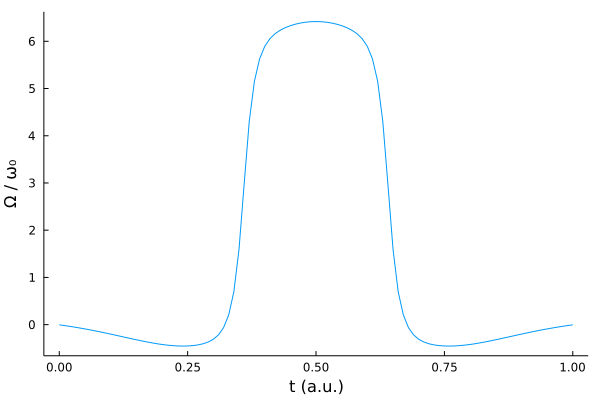

In [6]:
ts = t0:t1/100:t1

plot(ts, [Ω(sol.params, t) for t in ts])
plot!(xlabel="t (a.u.)", ylabel="Ω / ω₀", legend=false, grid=false)

We also run `schroedinger_dynamic` from QuantumOptics.jl to present how the system evolved over time and how the level population changed.

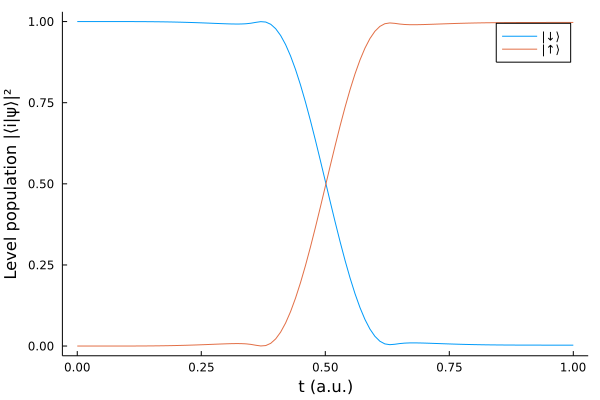

In [7]:
tout, psit = schroedinger_dynamic(ts, spindown(bs), H, sol.params)

plot(tout, real(expect(dm(spindown(bs)), psit)), label="|↓⟩")
plot!(tout, real(expect(dm(spinup(bs)), psit)), label="|↑⟩")
plot!(xlabel="t (a.u.)", ylabel="Level population |⟨i|ψ⟩|²", grid=false)